# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning - Project
---

## "Mind the Gap" - A Deep Learning Analysis of Pothole Detection
---

|                  Name                     |      Campus Email              | Personal Email        |
|-------------------------------------------|--------------------------------|-----------------------|
|[Itai Benyamin](https://github.com/Itai-b) | itai.b@campus.technion.ac.il   |itai.benyamin@gmail.com|
|[Idan Baruch](https://github.com/idanbaru) | idan-b@campus.technion.ac.il   |idanb12200@gmail.com   |

## Imports

In [74]:
import os
import gc
import shutil
import xmltodict
import random
import numpy as np
import optuna
import pandas as pd
import time
import copy
import re
from enum import Enum
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub as kh
from tqdm import tqdm
from torchmetrics.detection import MeanAveragePrecision

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin_memory = True if device == "cuda:0" else False

print("pytorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cuda.is_built())
print("Available devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No device")

pytorch version: 2.5.1
torchvision version: 0.20.1
Is CUDA available: True
CUDA version: 11.8
PyTorch built with CUDA: True
Available devices: 1
Current device: NVIDIA GeForce RTX 3090


## Data Loading

In [75]:
# Download the data using Kaggle API and save it to the data folder
#kaggle_datapath = 'andrewmvd/pothole-detection'
#data_path = 'data/andrewmvd_pothole_detection'
kaggle_datapath = 'chitholian/annotated-potholes-dataset'
data_path = 'data/chitholian_annotated_potholes_dataset'
if not os.path.exists(data_path):
    #Load the data from kaggle
    data = kh.dataset_download(kaggle_datapath)
    # Move the data to the correct location
    shutil.move(data, data_path)
    # if the data is from chitholian, we need to split it to two folders "images" and "annotations"
    if 'chitholian' in kaggle_datapath:
        # Create the folders
        os.makedirs(os.path.join(data_path, 'images'), exist_ok=True)
        os.makedirs(os.path.join(data_path, 'annotations'), exist_ok=True)
        # Move the files
        annotated_images_dir = os.path.join(data_path, 'annotated-images') 
        for file in os.listdir(annotated_images_dir):
            if file.endswith('.xml'):
                shutil.move(os.path.join(annotated_images_dir, file), os.path.join(data_path, 'annotations', file))
            else:
                shutil.move(os.path.join(annotated_images_dir, file), os.path.join(data_path, 'images', file))
        # remove the empty folder
        os.rmdir(annotated_images_dir)
else:
    print('Data already exists')

Data already exists


In [76]:
class PotholeSeverity(Enum):
    """
    Enum class for the severity of potholes.
    The severity levels ranges from 0 (no pothole) to 4 (major pothole):
        0 - No pothole (background, shouldn't be a detection target)
        temporary 1 - general pothole, no specific severity)
        1 - Minor pothole (road damage that is non-dangerous for padestrians)
        2 - Medium pothole (road damage that is dangerous for padestrians, but not for vehicles)
        3 - Major pothole (road damage that is dangerous for both vehicles and padestrians)
    """
    NO_POTHOLE = 0
    POTHOLE = 1 # TODO - this label is for temporary until we classify each saverity in the data.
    #MINOR_POTHOLE = 1
    #MEDIUM_POTHOLE = 2
    #MAJOR_POTHOLE = 3

def get_label_name(label):
    return PotholeSeverity(label).name

class PotholeDetectionDataset:
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        
        # Preprocess data
        self.img_files, self.ann_files = self._preprocess_dataset()

    
    @staticmethod
    def _extract_index(filename):
        # Use a regex to extract the numeric index from the file name
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')

    def _preprocess_dataset(self):
        # Get images from folder
        img_files = sorted(os.listdir(self.img_dir), key=self._extract_index)
        ann_files = sorted(os.listdir(self.ann_dir), key=self._extract_index)

        valid_img_files = []
        valid_ann_files = []

        # Parse images and annotated boxes to return only the valid images and boxes
        for img_file, ann_file in zip(img_files, ann_files):
            img_path = os.path.join(self.img_dir, img_file)
            ann_path = os.path.join(self.ann_dir, ann_file)
            
            # Load and validate
            img = cv2.imread(img_path)
            img_height, img_width = img.shape[:2]
            boxes, _ = self.parse_voc_annotation(ann_path)
            
            if self._check_boxes_validity(boxes, img_width, img_height):
                valid_img_files.append(img_file)
                valid_ann_files.append(ann_file)
                assert len(valid_img_files) == len(valid_ann_files)
        
        print(f'Number of valid images: {len(valid_img_files)}')
        return valid_img_files, valid_ann_files
    
    @staticmethod
    def _check_boxes_validity(boxes, img_width, img_height):
        for xmin, ymin, xmax, ymax in boxes:
            width = xmax - xmin
            height = ymax - ymin
            
            if width <= 0 or height <= 0:
                return False
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                return False
        return True

    def parse_voc_annotation(self, ann_path):
        with open(ann_path) as f:
            ann_data = xmltodict.parse(f.read())
        
        boxes = []
        labels = []
        objects = ann_data["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]
        
        for obj in objects:
            bbox = obj["bndbox"]
            xmin = int(float(bbox["xmin"]))
            ymin = int(float(bbox["ymin"]))
            xmax = int(float(bbox["xmax"]))
            ymax = int(float(bbox["ymax"]))
            boxes.append((xmin, ymin, xmax, ymax))
            labels.append(PotholeSeverity.POTHOLE.value)
        
        return boxes, labels
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # (height, width)
        
        # Load annotations
        boxes, labels = self.parse_voc_annotation(ann_path)
        
        # Apply transform
        if self.transform is not None:
            img_pil = torchvision.transforms.ToPILImage()(img)
            img = self.transform(img_pil)
            new_size = (img.shape[2], img.shape[1])  # (width, height)
            
            # Adjust bounding boxes
            orig_h, orig_w = original_size
            new_w, new_h = new_size
            x_scale = new_w / orig_w
            y_scale = new_h / orig_h
            boxes = [
                (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
                for xmin, ymin, xmax, ymax in boxes
            ]
            
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([idx], dtype=torch.int64),
                "area": torch.tensor([(xmax - xmin) * (ymax - ymin) for xmin, ymin, xmax, ymax in boxes], dtype=torch.float32),
            }

        return img, target
    
# custom collate_fn for torch DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [77]:
# Paths to images and annotations
#data_path = 'data/andrewmvd_pothole_detection'
img_dir = os.path.join(data_path,"images")
ann_dir = os.path.join(data_path,"annotations")

input_size = 300 # resize the images to 300x300

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
])

# Initialize the dataset
dataset = PotholeDetectionDataset(img_dir, ann_dir, transform=transform)

# Split the dataset to train, validation, and test sets (70-10-20)

# Maintain the original indices while splitting
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

print(f"Train set size: {len(train_set)} - {len(train_set)/len(dataset)*100:.2f}%")
print(f"Validation set size: {len(val_set)} - {len(val_set)/len(dataset)*100:.2f}%")
print(f"Test set size: {len(test_set)} - {len(test_set)/len(dataset)*100:.2f}%")


Number of valid images: 664
Train set size: 398 - 59.94%
Validation set size: 133 - 20.03%
Test set size: 133 - 20.03%


In [78]:
# normalize the images according to the mean and std of the training set
# DataLoader for train set
train_loader = DataLoader(train_set, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Initialize accumulators for mean and std
n_pixels = 0
mean_sum = torch.zeros(3)
squared_sum = torch.zeros(3)

for imgs, _ in train_loader:
    for img in imgs:
        img = img.view(3, -1)  # Flatten each channel
        n_pixels += img.size(1)  # Add the number of pixels per channel
        mean_sum += img.sum(dim=1)
        squared_sum += (img ** 2).sum(dim=1)

# Compute mean and std
mean = mean_sum / n_pixels
std = torch.sqrt(squared_sum / n_pixels - mean ** 2)

print(f"Training Set Mean: {mean}")
print(f"Training Set Std: {std}")

normalize = torchvision.transforms.Normalize(mean=mean.tolist(), std=std.tolist())

# Updated transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    normalize,
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    normalize,
])

# Recreate datasets with the updated transforms
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_test_transform
test_set.dataset.transform = val_test_transform

Training Set Mean: tensor([0.5272, 0.5146, 0.4907])
Training Set Std: tensor([0.1885, 0.1803, 0.1779])


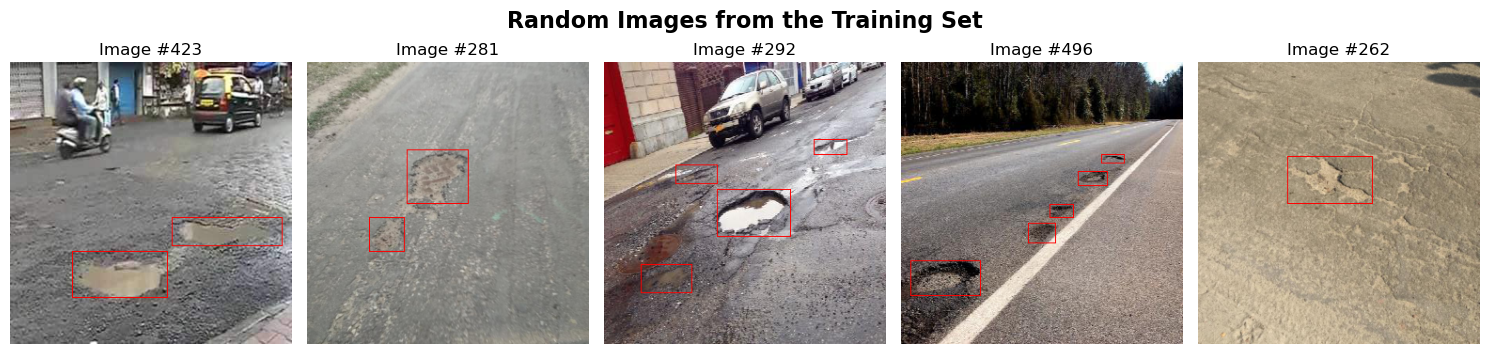

In [79]:
def convert_to_imshow_format(image, mean=mean, std=std):
    """
    Converts a normalized image tensor to the format expected by plt.imshow.
    Args:
        image (torch.Tensor): Normalized image tensor of shape [C, H, W].
        mean (torch.Tensor): Mean used for normalization (1D tensor of length 3 for RGB).
        std (torch.Tensor): Std used for normalization (1D tensor of length 3 for RGB).
    Returns:
        np.ndarray: Image array in HWC format, scaled to [0, 255] and uint8 type.
    """
    # Denormalize the image
    image = image * std[:, None, None] + mean[:, None, None]  # Reshape mean and std for broadcasting
    image = image.clamp(0, 1)  # Ensure values are in [0, 1] range
    
    # Convert to numpy and scale to [0, 255]
    image = (image.numpy() * 255).astype(np.uint8)
    
    # Convert from CHW to HWC
    return image.transpose(1, 2, 0)

# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)
images, targets = next(iter(train_loader))

# Create a figure with subplots
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for idx, (img, target) in enumerate(zip(images, targets)):
    # Convert image to imshow format
    img_np = convert_to_imshow_format(img, mean, std)
    img_np = np.ascontiguousarray(img_np)  # Ensure compatibility with OpenCV
    
    # Draw bounding boxes and labels
    for box, label in zip(target["boxes"], target["labels"]):
        cv2.rectangle(img_np,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      (255, 0, 0), 1)  # Blue box with thickness 2
        # label_name = get_label_name(label.item())
        # cv2.putText(img_np,
        #             label_name,
        #             (int(box[0]), int(box[1] - 5)),
        #             cv2.FONT_HERSHEY_SIMPLEX,
        #             0.5,
        #             (255, 0, 0), 1)  # Blue text
    
    # Display the image
    axes[idx].imshow(img_np)
    axes[idx].axis("off")
    axes[idx].set_title(f"Image #{target['image_id'].item()}")

plt.suptitle("Random Images from the Training Set", fontsize=16, fontweight="bold", y=0.85)

plt.tight_layout()
plt.show()

## Two Stage Object Detector - Faster R-CNN

In [80]:
def preprocess_bbox(prediction, threshold=0.5):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [81]:
def evaluate_model(model, data_loader, threshold=0.5, num_iterations=1, batch_size=5):
    metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
    metric.to(device)
    
    all_predictions={}
    total_avg_time = 0
    
    model.eval()
    with torch.no_grad():
        for imgs,targets in data_loader:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            
            start_time = time.time()
            for _ in range(num_iterations):
                predictions=model(imgs)
            end_time = time.time()
            
            total_avg_time += (end_time - start_time) / (num_iterations * batch_size)
            
            results=[]
            for prediction, target in zip(predictions, targets):
                image_id = target["image_id"].item()
                results.append(preprocess_bbox(prediction, threshold))
                all_predictions[image_id]=prediction
            metric.update(results,targets)
    
    avg_time_per_batch = total_avg_time / len(data_loader)
    fps = 1 / avg_time_per_batch
    
    maps=metric.compute()
    return all_predictions, maps, fps

In [82]:
from typing import List, Tuple
from torch import Tensor

# Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset) - pretrained
model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Replace the classifier with a single-class output
num_classes = len(PotholeSeverity)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


def custom_compute_loss(
    objectness: Tensor, pred_bbox_deltas: Tensor, labels: List[Tensor], regression_targets: List[Tensor]
) -> Tuple[Tensor, Tensor]:
    """
    Args:
        objectness (Tensor)
        pred_bbox_deltas (Tensor)
        labels (List[Tensor])
        regression_targets (List[Tensor])

    Returns:
        objectness_loss (Tensor)
        box_loss (Tensor)
    """
    sampled_pos_inds, sampled_neg_inds = model.rpn.fg_bg_sampler(labels)  # Access `fg_bg_sampler` from `model.rpn`
    sampled_pos_inds = torch.where(torch.cat(sampled_pos_inds, dim=0))[0]
    sampled_neg_inds = torch.where(torch.cat(sampled_neg_inds, dim=0))[0]

    sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)

    objectness = objectness.flatten()

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)

    box_loss = torchvision.ops.distance_box_iou_loss(
        pred_bbox_deltas[sampled_pos_inds],
        regression_targets[sampled_pos_inds],
        reduction="sum"
    ) / (sampled_inds.numel())

    objectness_loss = F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])

    return objectness_loss, box_loss

#overload the compute_loss function - add this after defining the model
#model.rpn.compute_loss = custom_compute_loss
#print(model.rpn.compute_loss)


In [83]:
## clear memory
gc.collect()
torch.cuda.empty_cache()

# Define the model (load pretrained weights of Resnet50-FPN on COCO_V1 dataset)
model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Replace the classifier with a single-class output
num_classes = len(PotholeSeverity)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 5

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10

best_model_state_dict = model.state_dict()
best_val_map = 0.0
best_epoch = 0

## clear memory
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:

        # Prepare inputs for the model
        images = [img.to(device) for img in images]

        # Convert relevant target values to device
        targets_to_device = []
        for target in targets:
            targets_to_device.append({
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            })
    
        # Compute loss
        loss_dict = model(images, targets_to_device)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Compute validation loss
    _ , val_map, fps = evaluate_model(model, val_loader, batch_size=batch_size)
    mean_ap = val_map["map_50"].item()
    
    if (mean_ap > best_val_map):
        best_val_map = mean_ap
        best_model_state_dict = copy.deepcopy(model.state_dict())
        best_epoch = epoch
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation mAP@50: {mean_ap:.4f}, FPS: {fps:.2f}")

# Save the best trained model:
torch.save(best_model_state_dict, "data/faster_rcnn/faster_rcnn_pothole.pth")
print(f"Best Epoch: {best_epoch + 1}, Best Val mAP@50: {best_val_map:.4f}")
print("Model training complete. Saved as 'faster_rcnn_pothole.pth'.")

Epoch 1/10, Loss: 34.9158, Validation mAP@50: 0.5377, FPS: 49.16
Epoch 2/10, Loss: 23.1198, Validation mAP@50: 0.5818, FPS: 49.29
Epoch 3/10, Loss: 18.3785, Validation mAP@50: 0.6672, FPS: 49.54
Epoch 4/10, Loss: 14.0390, Validation mAP@50: 0.6918, FPS: 49.34
Epoch 5/10, Loss: 12.7160, Validation mAP@50: 0.6935, FPS: 49.77
Epoch 6/10, Loss: 12.0691, Validation mAP@50: 0.6968, FPS: 48.89
Epoch 7/10, Loss: 11.4124, Validation mAP@50: 0.6976, FPS: 49.12
Epoch 8/10, Loss: 11.3069, Validation mAP@50: 0.6980, FPS: 48.32
Epoch 9/10, Loss: 11.3618, Validation mAP@50: 0.6979, FPS: 48.25
Epoch 10/10, Loss: 11.2133, Validation mAP@50: 0.6980, FPS: 48.33
Best Epoch: 10, Best Val mAP@50: 0.6980
Model training complete. Saved as 'faster_rcnn_pothole.pth'.


In [84]:
import json

def get_optimizer(trial, model_parameters):
    # Suggest optimizer type
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'AdamW', 'RMSprop'])
    
    # Common parameters
    
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.9, 0.99)
        lr = trial.suggest_float('lr', 5e-3, 5e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        return torch.optim.SGD(model_parameters, lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    elif optimizer_name == 'Adam':
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        beta1 = trial.suggest_float('beta1', 0.8, 0.999)
        beta2 = trial.suggest_float('beta2', 0.9, 0.999)
        return torch.optim.Adam(model_parameters, lr=lr, betas=(beta1, beta2))
    
    elif optimizer_name == 'AdamW':
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-2, log=True)
        beta1 = trial.suggest_float('beta1', 0.8, 0.999)
        beta2 = trial.suggest_float('beta2', 0.9, 0.999)
        return torch.optim.AdamW(model_parameters, lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
    
    else:  # RMSprop
        lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-1, 1, log=True)
        momentum = trial.suggest_float('momentum', 0.9, 0.99)
        return torch.optim.RMSprop(model_parameters, lr=lr, momentum=momentum, weight_decay=weight_decay)

def get_scheduler(trial, optimizer, num_epochs):
    # Suggest scheduler type
    scheduler_name = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR', 'ReduceLROnPlateau', 'OneCycleLR'])
    
    if scheduler_name == 'StepLR':
        step_size = trial.suggest_int('step_size', 2, 5)
        gamma = trial.suggest_float('gamma', 0.05, 0.5)
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    elif scheduler_name == 'CosineAnnealingLR':
        T_max = trial.suggest_int('T_max', 5, 15)
        eta_min = trial.suggest_float('eta_min', 1e-7, 1e-5, log=True)
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    
    elif scheduler_name == 'ReduceLROnPlateau':
        factor = trial.suggest_float('factor', 0.1, 0.5)
        patience = trial.suggest_int('patience', 2, 5)
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
    
    else:  # OneCycleLR
        max_lr = trial.suggest_float('max_lr', 1e-4, 1e-2, log=True)
        return torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

def objective(trial): 
    ## clear memory
    gc.collect()
    torch.cuda.empty_cache()
    
    # Define hyperparameter search space
    batch_size = trial.suggest_int('batch_size', 4, 8)
    num_epochs = trial.suggest_int('epochs', 10, 20)
    preweight_mode = trial.suggest_categorical('preweight_mode', ['freezing', 'fine_tuning', 'random'])

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Define the model
    if preweight_mode == 'random':
        model = models.detection.fasterrcnn_resnet50_fpn()  # No pre-trained weights
    else:
        model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

    # Replace the classifier with a single-class output
    num_classes = len(PotholeSeverity)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 
    
    if preweight_mode == 'freezing':
        # Freeze all layers except the head
        for param in model.parameters():
            param.requires_grad = False
        for param in model.roi_heads.box_predictor.parameters():
            param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Get optimizer and scheduler
    optimizer = get_optimizer(trial, model.parameters())
    scheduler = get_scheduler(trial, optimizer, num_epochs)
    
    # Training loop
    best_model_state_dict = model.state_dict
    best_map = 0.0
    prev_map = 0.0
    patience_counter = 0
    max_patience = 3  # Early stopping patience
    map_diff_threshold = 1e-2
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets_to_device = [{
                'boxes': target['boxes'].to(device),
                'labels': target['labels'].to(device)
            } for target in targets]
            
            loss_dict = model(images, targets_to_device)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        # Evaluate on validation set
        _, val_map, fps = evaluate_model(model, val_loader, batch_size=batch_size)
        mean_ap = val_map["map_50"].item()
        
        # Step the scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(mean_ap)
        else:
            scheduler.step()
        
        # Report intermediate value
        trial.report(mean_ap, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        # Track best MAP and early stopping
        if mean_ap > best_map:
            patience_counter = 0
            best_map = mean_ap
            best_model_state_dict = copy.deepcopy(model.state_dict())
        elif (np.abs(mean_ap - prev_map) < map_diff_threshold):
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
        
        torch.save(best_model_state_dict, f"./data/faster_rcnn/optuna/model_trial_{trial.number}_best.pth")

        print(f"Trial {trial.number} Epoch {epoch + 1}/{num_epochs}, "
              f"Loss: {epoch_loss:.4f}, Validation mAP@50: {mean_ap:.4f}, "
              f"FPS: {fps:.2f}")
        prev_map = mean_ap
        
    return best_map

def run_optimization(n_trials=50, optuna_path=None):
    study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5),
        study_name="faster_rcnn_optimization",
        sampler=optuna.samplers.TPESampler(seed=seed)
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    # Print optimization results
    trial = study.best_trial
    print(f"\nBest trial: #{trial.number}")
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # Plot optimization history
    try:
        import plotly
        fig = optuna.visualization.plot_optimization_history(study)
        fig.write_html(os.path.join(optuna_path,"optimization_history.html"))
        
        fig_importance = optuna.visualization.plot_param_importances(study)
        fig_importance.write_html(os.path.join(optuna_path,"parameter_importance.html"))
    except (ImportError, RuntimeError) as e:
        print("Plotting failed:", str(e))
    
    # Save study results
    study.trials_dataframe().to_csv(os.path.join(optuna_path,"optimization_results.csv"))
    
    return study

# Run the optimization
optuna_path = f'data/faster_rcnn/optuna'
study = run_optimization(n_trials=50, optuna_path=optuna_path)

[I 2025-01-22 10:12:21,705] A new study created in memory with name: faster_rcnn_optimization


Trial 0 Epoch 1/17, Loss: 64.4540, Validation mAP@50: 0.0000, FPS: 49.12
Trial 0 Epoch 2/17, Loss: 20.7944, Validation mAP@50: 0.0000, FPS: 48.68


[I 2025-01-22 10:13:31,248] Trial 0 finished with value: 0.0 and parameters: {'batch_size': 7, 'epochs': 17, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.0009472961959721175, 'beta1': 0.9658118084445251, 'beta2': 0.9318563294010559, 'scheduler': 'CosineAnnealingLR', 'T_max': 8, 'eta_min': 8.307341815284441e-06}. Best is trial 0 with value: 0.0.


Early stopping triggered at epoch 3
Trial 1 Epoch 1/13, Loss: 38.5404, Validation mAP@50: 0.0033, FPS: 51.77
Trial 1 Epoch 2/13, Loss: 34.7123, Validation mAP@50: 0.0463, FPS: 50.93
Trial 1 Epoch 3/13, Loss: 33.6090, Validation mAP@50: 0.0575, FPS: 50.82
Trial 1 Epoch 4/13, Loss: 33.6335, Validation mAP@50: 0.0564, FPS: 50.60
Trial 1 Epoch 5/13, Loss: 33.3562, Validation mAP@50: 0.0618, FPS: 49.62
Trial 1 Epoch 6/13, Loss: 33.0021, Validation mAP@50: 0.0758, FPS: 50.60
Trial 1 Epoch 7/13, Loss: 33.1810, Validation mAP@50: 0.0768, FPS: 51.67
Trial 1 Epoch 8/13, Loss: 32.9205, Validation mAP@50: 0.0832, FPS: 51.43
Trial 1 Epoch 9/13, Loss: 32.9179, Validation mAP@50: 0.0825, FPS: 52.30
Trial 1 Epoch 10/13, Loss: 32.7391, Validation mAP@50: 0.0819, FPS: 52.21


[I 2025-01-22 10:16:25,750] Trial 1 finished with value: 0.08315115422010422 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'freezing', 'optimizer': 'Adam', 'lr': 0.0004904539339172869, 'beta1': 0.9169765854389738, 'beta2': 0.9282853454922604, 'scheduler': 'StepLR', 'step_size': 5, 'gamma': 0.16714116943161034}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 11
Trial 2 Epoch 1/17, Loss: nan, Validation mAP@50: 0.0000, FPS: 64.00
Trial 2 Epoch 2/17, Loss: nan, Validation mAP@50: 0.0000, FPS: 64.69


[I 2025-01-22 10:17:22,832] Trial 2 finished with value: 0.0 and parameters: {'batch_size': 8, 'epochs': 17, 'preweight_mode': 'fine_tuning', 'optimizer': 'RMSprop', 'lr': 0.004241247429282568, 'weight_decay': 0.1260926568334326, 'momentum': 0.9492067843282642, 'scheduler': 'StepLR', 'step_size': 5, 'gamma': 0.17734318931932058}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 3
Trial 3 Epoch 1/13, Loss: nan, Validation mAP@50: 0.0000, FPS: 62.99
Trial 3 Epoch 2/13, Loss: nan, Validation mAP@50: 0.0000, FPS: 63.75


[I 2025-01-22 10:18:20,726] Trial 3 finished with value: 0.0 and parameters: {'batch_size': 8, 'epochs': 13, 'preweight_mode': 'fine_tuning', 'optimizer': 'SGD', 'momentum': 0.9895977596972944, 'lr': 0.016590045793740463, 'weight_decay': 5.129973236412686e-05, 'scheduler': 'StepLR', 'step_size': 5, 'gamma': 0.056083539958035666}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 3
Trial 4 Epoch 1/17, Loss: 46.5971, Validation mAP@50: 0.0000, FPS: 50.25
Trial 4 Epoch 2/17, Loss: 26.9142, Validation mAP@50: 0.0000, FPS: 49.89


[I 2025-01-22 10:19:30,907] Trial 4 finished with value: 0.0 and parameters: {'batch_size': 6, 'epochs': 17, 'preweight_mode': 'random', 'optimizer': 'SGD', 'momentum': 0.9603940213174831, 'lr': 0.032155547841981214, 'weight_decay': 4.760099310748672e-05, 'scheduler': 'OneCycleLR', 'max_lr': 0.004548729885792942}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 3
Trial 5 Epoch 1/17, Loss: nan, Validation mAP@50: 0.0000, FPS: 60.65
Trial 5 Epoch 2/17, Loss: nan, Validation mAP@50: 0.0000, FPS: 59.68


[I 2025-01-22 10:20:30,633] Trial 5 finished with value: 0.0 and parameters: {'batch_size': 7, 'epochs': 17, 'preweight_mode': 'random', 'optimizer': 'RMSprop', 'lr': 0.0012548593198908888, 'weight_decay': 0.5380377852807633, 'momentum': 0.9780810792026231, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.2973243346544745, 'patience': 3}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 3
Trial 6 Epoch 1/16, Loss: 26.7808, Validation mAP@50: 0.0000, FPS: 47.81
Trial 6 Epoch 2/16, Loss: 24.3881, Validation mAP@50: 0.0000, FPS: 47.95


[I 2025-01-22 10:21:40,958] Trial 6 finished with value: 0.0 and parameters: {'batch_size': 7, 'epochs': 16, 'preweight_mode': 'random', 'optimizer': 'SGD', 'momentum': 0.947830250449445, 'lr': 0.0083742433416178, 'weight_decay': 1.0003658748852571e-05, 'scheduler': 'CosineAnnealingLR', 'T_max': 5, 'eta_min': 4.0935047202991817e-07}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 3
Trial 7 Epoch 1/17, Loss: nan, Validation mAP@50: 0.0000, FPS: 63.70
Trial 7 Epoch 2/17, Loss: nan, Validation mAP@50: 0.0000, FPS: 64.68


[I 2025-01-22 10:22:39,666] Trial 7 finished with value: 0.0 and parameters: {'batch_size': 6, 'epochs': 17, 'preweight_mode': 'fine_tuning', 'optimizer': 'RMSprop', 'lr': 0.0035675054331891385, 'weight_decay': 0.10566344366433493, 'momentum': 0.9775188644231251, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.29754314502094625, 'patience': 2}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 3
Trial 8 Epoch 1/14, Loss: 52.7675, Validation mAP@50: 0.0407, FPS: 49.19
Trial 8 Epoch 2/14, Loss: 31.0461, Validation mAP@50: 0.0271, FPS: 49.99
Trial 8 Epoch 3/14, Loss: 30.9985, Validation mAP@50: 0.0174, FPS: 49.44
Trial 8 Epoch 4/14, Loss: 30.3202, Validation mAP@50: 0.0147, FPS: 49.38


[I 2025-01-22 10:23:58,286] Trial 8 finished with value: 0.04073403775691986 and parameters: {'batch_size': 7, 'epochs': 14, 'preweight_mode': 'freezing', 'optimizer': 'RMSprop', 'lr': 0.0010523472087119428, 'weight_decay': 0.11239553251294436, 'momentum': 0.902710004059513, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.13439332022060319, 'patience': 4}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 5
Trial 9 Epoch 1/18, Loss: 33.6777, Validation mAP@50: 0.0758, FPS: 47.55
Trial 9 Epoch 2/18, Loss: 26.8215, Validation mAP@50: 0.0000, FPS: 48.02
Trial 9 Epoch 3/18, Loss: 27.2096, Validation mAP@50: 0.0000, FPS: 46.67
Trial 9 Epoch 4/18, Loss: 30.0482, Validation mAP@50: 0.0000, FPS: 47.29


[I 2025-01-22 10:25:55,610] Trial 9 finished with value: 0.07578173279762268 and parameters: {'batch_size': 7, 'epochs': 18, 'preweight_mode': 'fine_tuning', 'optimizer': 'SGD', 'momentum': 0.9831718577670245, 'lr': 0.007603115846075662, 'weight_decay': 3.626824917046231e-05, 'scheduler': 'CosineAnnealingLR', 'T_max': 12, 'eta_min': 8.368075421103245e-07}. Best is trial 1 with value: 0.08315115422010422.


Early stopping triggered at epoch 5
Trial 10 Epoch 1/10, Loss: 56.9800, Validation mAP@50: 0.0000, FPS: 48.28
Trial 10 Epoch 2/10, Loss: 52.4428, Validation mAP@50: 0.0271, FPS: 48.47
Trial 10 Epoch 3/10, Loss: 51.8585, Validation mAP@50: 0.0239, FPS: 48.39
Trial 10 Epoch 4/10, Loss: 50.9972, Validation mAP@50: 0.0383, FPS: 48.37
Trial 10 Epoch 5/10, Loss: 50.9723, Validation mAP@50: 0.0423, FPS: 48.91


[I 2025-01-22 10:27:33,641] Trial 10 pruned. 


Trial 11 Epoch 1/20, Loss: 46.7261, Validation mAP@50: 0.0000, FPS: 47.85
Trial 11 Epoch 2/20, Loss: 42.1212, Validation mAP@50: 0.0000, FPS: 48.73
Trial 11 Epoch 3/20, Loss: 41.2288, Validation mAP@50: 0.0275, FPS: 49.83
Trial 11 Epoch 4/20, Loss: 40.7963, Validation mAP@50: 0.0418, FPS: 48.83
Trial 11 Epoch 5/20, Loss: 40.5229, Validation mAP@50: 0.0678, FPS: 49.10
Trial 11 Epoch 6/20, Loss: 40.0811, Validation mAP@50: 0.0759, FPS: 48.61
Trial 11 Epoch 7/20, Loss: 39.8959, Validation mAP@50: 0.0839, FPS: 48.96
Trial 11 Epoch 8/20, Loss: 39.7958, Validation mAP@50: 0.0833, FPS: 48.87
Trial 11 Epoch 9/20, Loss: 39.3136, Validation mAP@50: 0.0852, FPS: 47.81
Trial 11 Epoch 10/20, Loss: 39.4889, Validation mAP@50: 0.0845, FPS: 47.63
Trial 11 Epoch 11/20, Loss: 39.3179, Validation mAP@50: 0.0820, FPS: 48.48
Trial 11 Epoch 12/20, Loss: 39.4821, Validation mAP@50: 0.0863, FPS: 47.76
Trial 11 Epoch 13/20, Loss: 39.5217, Validation mAP@50: 0.0871, FPS: 47.95
Trial 11 Epoch 14/20, Loss: 39.127

[I 2025-01-22 10:32:59,518] Trial 11 finished with value: 0.09358001500368118 and parameters: {'batch_size': 5, 'epochs': 20, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.0003694523475879222, 'weight_decay': 0.0023475904393329278, 'beta1': 0.9290952610210181, 'beta2': 0.9893724206600294, 'scheduler': 'CosineAnnealingLR', 'T_max': 15, 'eta_min': 1.0038409917847292e-07}. Best is trial 11 with value: 0.09358001500368118.


Trial 11 Epoch 20/20, Loss: 39.3637, Validation mAP@50: 0.0913, FPS: 48.94
Trial 12 Epoch 1/20, Loss: 157.0384, Validation mAP@50: 0.0007, FPS: 48.08
Trial 12 Epoch 2/20, Loss: 130.8505, Validation mAP@50: 0.0011, FPS: 48.29
Trial 12 Epoch 3/20, Loss: 108.9887, Validation mAP@50: 0.0017, FPS: 49.57
Trial 12 Epoch 4/20, Loss: 92.7588, Validation mAP@50: 0.0026, FPS: 51.53
Trial 12 Epoch 5/20, Loss: 80.7436, Validation mAP@50: 0.0026, FPS: 51.30


[I 2025-01-22 10:34:41,082] Trial 12 pruned. 


Trial 13 Epoch 1/12, Loss: 47.7826, Validation mAP@50: 0.0000, FPS: 52.98
Trial 13 Epoch 2/12, Loss: 41.9428, Validation mAP@50: 0.0099, FPS: 51.00
Trial 13 Epoch 3/12, Loss: 40.9208, Validation mAP@50: 0.0559, FPS: 49.29
Trial 13 Epoch 4/12, Loss: 40.4780, Validation mAP@50: 0.0516, FPS: 49.65
Trial 13 Epoch 5/12, Loss: 39.9952, Validation mAP@50: 0.0705, FPS: 49.41


[I 2025-01-22 10:36:15,413] Trial 13 pruned. 


Trial 14 Epoch 1/20, Loss: 46.9691, Validation mAP@50: 0.0141, FPS: 52.85
Trial 14 Epoch 2/20, Loss: 41.1696, Validation mAP@50: 0.0350, FPS: 52.95
Trial 14 Epoch 3/20, Loss: 40.7990, Validation mAP@50: 0.0596, FPS: 50.56
Trial 14 Epoch 4/20, Loss: 40.0632, Validation mAP@50: 0.0633, FPS: 51.20
Trial 14 Epoch 5/20, Loss: 39.8275, Validation mAP@50: 0.0746, FPS: 49.36
Trial 14 Epoch 6/20, Loss: 39.6736, Validation mAP@50: 0.0801, FPS: 50.52
Trial 14 Epoch 7/20, Loss: 39.6249, Validation mAP@50: 0.0862, FPS: 51.36
Trial 14 Epoch 8/20, Loss: 39.3845, Validation mAP@50: 0.0807, FPS: 50.50
Trial 14 Epoch 9/20, Loss: 39.7715, Validation mAP@50: 0.0838, FPS: 50.10


[I 2025-01-22 10:38:52,061] Trial 14 finished with value: 0.08617264032363892 and parameters: {'batch_size': 5, 'epochs': 20, 'preweight_mode': 'freezing', 'optimizer': 'Adam', 'lr': 0.0004386469437490743, 'beta1': 0.9188829643751535, 'beta2': 0.9510102685339952, 'scheduler': 'StepLR', 'step_size': 4, 'gamma': 0.27775020079423574}. Best is trial 11 with value: 0.09358001500368118.


Early stopping triggered at epoch 10
Trial 15 Epoch 1/20, Loss: 63.6103, Validation mAP@50: 0.0000, FPS: 50.51
Trial 15 Epoch 2/20, Loss: 64.8996, Validation mAP@50: 0.0000, FPS: 49.92
Trial 15 Epoch 3/20, Loss: 60.6139, Validation mAP@50: 0.0099, FPS: 48.96
Trial 15 Epoch 4/20, Loss: 54.8953, Validation mAP@50: 0.0455, FPS: 48.98
Trial 15 Epoch 5/20, Loss: 54.8801, Validation mAP@50: 0.0483, FPS: 49.05


[I 2025-01-22 10:40:29,401] Trial 15 pruned. 


Trial 16 Epoch 1/19, Loss: 43.3507, Validation mAP@50: 0.0000, FPS: 48.74
Trial 16 Epoch 2/19, Loss: 41.4145, Validation mAP@50: 0.0541, FPS: 49.14
Trial 16 Epoch 3/19, Loss: 40.3909, Validation mAP@50: 0.0573, FPS: 46.64
Trial 16 Epoch 4/19, Loss: 40.0887, Validation mAP@50: 0.0782, FPS: 47.13
Trial 16 Epoch 5/19, Loss: 39.8526, Validation mAP@50: 0.0815, FPS: 47.17
Trial 16 Epoch 6/19, Loss: 39.6399, Validation mAP@50: 0.0942, FPS: 47.33
Trial 16 Epoch 7/19, Loss: 39.4590, Validation mAP@50: 0.0927, FPS: 48.32
Trial 16 Epoch 8/19, Loss: 39.3127, Validation mAP@50: 0.0962, FPS: 46.59
Trial 16 Epoch 9/19, Loss: 39.5342, Validation mAP@50: 0.0895, FPS: 48.79
Trial 16 Epoch 10/19, Loss: 39.5478, Validation mAP@50: 0.0881, FPS: 49.18
Trial 16 Epoch 11/19, Loss: 39.3865, Validation mAP@50: 0.0989, FPS: 49.18
Trial 16 Epoch 12/19, Loss: 39.1331, Validation mAP@50: 0.0954, FPS: 49.31
Trial 16 Epoch 13/19, Loss: 38.9909, Validation mAP@50: 0.0974, FPS: 48.69
Trial 16 Epoch 14/19, Loss: 39.288

[I 2025-01-22 10:45:06,532] Trial 16 finished with value: 0.10286477953195572 and parameters: {'batch_size': 5, 'epochs': 19, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.0005937884170139257, 'weight_decay': 0.001905481525254186, 'beta1': 0.8183399362169581, 'beta2': 0.9865028077973771, 'scheduler': 'CosineAnnealingLR', 'T_max': 15, 'eta_min': 1.0374076769934224e-07}. Best is trial 16 with value: 0.10286477953195572.


Early stopping triggered at epoch 17
Trial 17 Epoch 1/19, Loss: 43.8995, Validation mAP@50: 0.0099, FPS: 48.94
Trial 17 Epoch 2/19, Loss: 41.3122, Validation mAP@50: 0.0485, FPS: 51.34
Trial 17 Epoch 3/19, Loss: 40.5903, Validation mAP@50: 0.0640, FPS: 52.86
Trial 17 Epoch 4/19, Loss: 40.4079, Validation mAP@50: 0.0822, FPS: 52.89
Trial 17 Epoch 5/19, Loss: 40.3253, Validation mAP@50: 0.0813, FPS: 50.70
Trial 17 Epoch 6/19, Loss: 39.8854, Validation mAP@50: 0.0831, FPS: 50.82
Trial 17 Epoch 7/19, Loss: 39.3231, Validation mAP@50: 0.0970, FPS: 50.71
Trial 17 Epoch 8/19, Loss: 39.2251, Validation mAP@50: 0.0883, FPS: 52.88
Trial 17 Epoch 9/19, Loss: 39.1735, Validation mAP@50: 0.0953, FPS: 52.98


[I 2025-01-22 10:47:42,973] Trial 17 finished with value: 0.09699471294879913 and parameters: {'batch_size': 5, 'epochs': 19, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.000705839184297443, 'weight_decay': 0.001747797111607088, 'beta1': 0.8017704059315538, 'beta2': 0.9962527116041862, 'scheduler': 'CosineAnnealingLR', 'T_max': 15, 'eta_min': 1.0486460537958847e-07}. Best is trial 16 with value: 0.10286477953195572.


Early stopping triggered at epoch 10
Trial 18 Epoch 1/19, Loss: 53.4807, Validation mAP@50: 0.0426, FPS: 53.58
Trial 18 Epoch 2/19, Loss: 50.8955, Validation mAP@50: 0.0685, FPS: 53.64
Trial 18 Epoch 3/19, Loss: 49.6732, Validation mAP@50: 0.0900, FPS: 53.17
Trial 18 Epoch 4/19, Loss: 50.6540, Validation mAP@50: 0.0727, FPS: 53.56
Trial 18 Epoch 5/19, Loss: 49.3149, Validation mAP@50: 0.1066, FPS: 53.51
Trial 18 Epoch 6/19, Loss: 48.7498, Validation mAP@50: 0.1037, FPS: 53.63
Trial 18 Epoch 7/19, Loss: 48.7599, Validation mAP@50: 0.1411, FPS: 53.70
Trial 18 Epoch 8/19, Loss: 48.5044, Validation mAP@50: 0.1331, FPS: 53.69
Trial 18 Epoch 9/19, Loss: 48.6406, Validation mAP@50: 0.1502, FPS: 53.48
Trial 18 Epoch 10/19, Loss: 48.6564, Validation mAP@50: 0.1253, FPS: 53.50
Trial 18 Epoch 11/19, Loss: 48.3105, Validation mAP@50: 0.1362, FPS: 54.11
Trial 18 Epoch 12/19, Loss: 48.1612, Validation mAP@50: 0.1282, FPS: 54.08
Trial 18 Epoch 13/19, Loss: 48.2316, Validation mAP@50: 0.1282, FPS: 53.

[I 2025-01-22 10:51:15,528] Trial 18 finished with value: 0.15023323893547058 and parameters: {'batch_size': 4, 'epochs': 19, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.001488737230096911, 'weight_decay': 0.0018263029493624926, 'beta1': 0.8076061185740394, 'beta2': 0.9808411925682963, 'scheduler': 'CosineAnnealingLR', 'T_max': 12, 'eta_min': 2.4777513355397695e-07}. Best is trial 18 with value: 0.15023323893547058.


Early stopping triggered at epoch 14
Trial 19 Epoch 1/15, Loss: 53.8245, Validation mAP@50: 0.0560, FPS: 53.84
Trial 19 Epoch 2/15, Loss: 50.2222, Validation mAP@50: 0.0808, FPS: 53.62
Trial 19 Epoch 3/15, Loss: 49.9339, Validation mAP@50: 0.1196, FPS: 53.66
Trial 19 Epoch 4/15, Loss: 50.2611, Validation mAP@50: 0.0946, FPS: 53.62
Trial 19 Epoch 5/15, Loss: 49.3258, Validation mAP@50: 0.1508, FPS: 53.67
Trial 19 Epoch 6/15, Loss: 49.4480, Validation mAP@50: 0.1608, FPS: 53.61
Trial 19 Epoch 7/15, Loss: 48.9839, Validation mAP@50: 0.1096, FPS: 53.64
Trial 19 Epoch 8/15, Loss: 48.7451, Validation mAP@50: 0.1430, FPS: 53.65
Trial 19 Epoch 9/15, Loss: 48.5776, Validation mAP@50: 0.1219, FPS: 53.62
Trial 19 Epoch 10/15, Loss: 48.2057, Validation mAP@50: 0.1427, FPS: 53.17
Trial 19 Epoch 11/15, Loss: 47.7743, Validation mAP@50: 0.1494, FPS: 53.63
Trial 19 Epoch 12/15, Loss: 47.9210, Validation mAP@50: 0.1494, FPS: 53.52


[I 2025-01-22 10:54:33,032] Trial 19 finished with value: 0.160805344581604 and parameters: {'batch_size': 4, 'epochs': 15, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.0018801623357432786, 'weight_decay': 0.0015271410357262085, 'beta1': 0.807188414206595, 'beta2': 0.9732916875613865, 'scheduler': 'CosineAnnealingLR', 'T_max': 11, 'eta_min': 3.457810755936053e-07}. Best is trial 19 with value: 0.160805344581604.


Early stopping triggered at epoch 13
Trial 20 Epoch 1/15, Loss: 53.9065, Validation mAP@50: 0.0749, FPS: 53.52
Trial 20 Epoch 2/15, Loss: 50.4757, Validation mAP@50: 0.0802, FPS: 53.62
Trial 20 Epoch 3/15, Loss: 50.5649, Validation mAP@50: 0.1059, FPS: 53.59
Trial 20 Epoch 4/15, Loss: 49.6587, Validation mAP@50: 0.1311, FPS: 53.60
Trial 20 Epoch 5/15, Loss: 49.4108, Validation mAP@50: 0.1116, FPS: 53.64
Trial 20 Epoch 6/15, Loss: 48.3138, Validation mAP@50: 0.1144, FPS: 53.68
Trial 20 Epoch 7/15, Loss: 48.9403, Validation mAP@50: 0.1004, FPS: 53.57
Trial 20 Epoch 8/15, Loss: 48.6465, Validation mAP@50: 0.1403, FPS: 53.62
Trial 20 Epoch 9/15, Loss: 47.8636, Validation mAP@50: 0.1360, FPS: 53.63
Trial 20 Epoch 10/15, Loss: 48.2525, Validation mAP@50: 0.1314, FPS: 53.66


[I 2025-01-22 10:57:20,976] Trial 20 finished with value: 0.1403011977672577 and parameters: {'batch_size': 4, 'epochs': 15, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.001820618760169731, 'weight_decay': 0.0014318867784728878, 'beta1': 0.8412809751314814, 'beta2': 0.9646041258960092, 'scheduler': 'CosineAnnealingLR', 'T_max': 11, 'eta_min': 4.7305234214435013e-07}. Best is trial 19 with value: 0.160805344581604.


Early stopping triggered at epoch 11
Trial 21 Epoch 1/15, Loss: 55.0125, Validation mAP@50: 0.0527, FPS: 53.62
Trial 21 Epoch 2/15, Loss: 50.7866, Validation mAP@50: 0.0591, FPS: 53.68
Trial 21 Epoch 3/15, Loss: 50.1796, Validation mAP@50: 0.0881, FPS: 53.70
Trial 21 Epoch 4/15, Loss: 49.5581, Validation mAP@50: 0.0976, FPS: 53.55
Trial 21 Epoch 5/15, Loss: 49.2144, Validation mAP@50: 0.1453, FPS: 53.67
Trial 21 Epoch 6/15, Loss: 48.7435, Validation mAP@50: 0.1412, FPS: 53.67
Trial 21 Epoch 7/15, Loss: 49.0987, Validation mAP@50: 0.1429, FPS: 53.67
Trial 21 Epoch 8/15, Loss: 48.6746, Validation mAP@50: 0.1074, FPS: 53.69
Trial 21 Epoch 9/15, Loss: 48.4125, Validation mAP@50: 0.1314, FPS: 53.64


[I 2025-01-22 10:59:52,851] Trial 21 finished with value: 0.14531247317790985 and parameters: {'batch_size': 4, 'epochs': 15, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.0018625237150593755, 'weight_decay': 0.0014196155646984138, 'beta1': 0.8371145940786276, 'beta2': 0.9658775405645393, 'scheduler': 'CosineAnnealingLR', 'T_max': 11, 'eta_min': 4.2987794700519877e-07}. Best is trial 19 with value: 0.160805344581604.


Early stopping triggered at epoch 10
Trial 22 Epoch 1/15, Loss: 54.2894, Validation mAP@50: 0.0397, FPS: 53.63
Trial 22 Epoch 2/15, Loss: 50.7507, Validation mAP@50: 0.0491, FPS: 53.62
Trial 22 Epoch 3/15, Loss: 50.5154, Validation mAP@50: 0.0917, FPS: 53.86
Trial 22 Epoch 4/15, Loss: 49.3716, Validation mAP@50: 0.1225, FPS: 54.01
Trial 22 Epoch 5/15, Loss: 49.3080, Validation mAP@50: 0.1207, FPS: 53.63
Trial 22 Epoch 6/15, Loss: 49.1612, Validation mAP@50: 0.1256, FPS: 53.68
Trial 22 Epoch 7/15, Loss: 48.7821, Validation mAP@50: 0.1032, FPS: 53.65
Trial 22 Epoch 8/15, Loss: 48.2731, Validation mAP@50: 0.1385, FPS: 53.61
Trial 22 Epoch 9/15, Loss: 48.5732, Validation mAP@50: 0.1246, FPS: 53.64
Trial 22 Epoch 10/15, Loss: 48.4472, Validation mAP@50: 0.1314, FPS: 53.66
Trial 22 Epoch 11/15, Loss: 48.1860, Validation mAP@50: 0.1315, FPS: 53.63
Trial 22 Epoch 12/15, Loss: 48.6164, Validation mAP@50: 0.1396, FPS: 53.60
Trial 22 Epoch 13/15, Loss: 48.1344, Validation mAP@50: 0.1395, FPS: 53.

[I 2025-01-22 11:03:40,960] Trial 22 finished with value: 0.14408546686172485 and parameters: {'batch_size': 4, 'epochs': 15, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.002138605524260109, 'weight_decay': 0.001359729079346307, 'beta1': 0.8374465535759265, 'beta2': 0.9767990732643879, 'scheduler': 'CosineAnnealingLR', 'T_max': 12, 'eta_min': 3.461767024753883e-07}. Best is trial 19 with value: 0.160805344581604.


Trial 22 Epoch 15/15, Loss: 47.7734, Validation mAP@50: 0.1441, FPS: 53.56
Trial 23 Epoch 1/14, Loss: 53.8838, Validation mAP@50: 0.0613, FPS: 53.49
Trial 23 Epoch 2/14, Loss: 50.4363, Validation mAP@50: 0.0572, FPS: 53.62
Trial 23 Epoch 3/14, Loss: 49.9009, Validation mAP@50: 0.1359, FPS: 53.61
Trial 23 Epoch 4/14, Loss: 49.5801, Validation mAP@50: 0.1236, FPS: 53.61
Trial 23 Epoch 5/14, Loss: 49.3799, Validation mAP@50: 0.1343, FPS: 53.65
Trial 23 Epoch 6/14, Loss: 49.0003, Validation mAP@50: 0.1079, FPS: 53.64
Trial 23 Epoch 7/14, Loss: 48.7699, Validation mAP@50: 0.1483, FPS: 53.60
Trial 23 Epoch 8/14, Loss: 48.4933, Validation mAP@50: 0.1201, FPS: 53.69
Trial 23 Epoch 9/14, Loss: 48.3190, Validation mAP@50: 0.1356, FPS: 53.77
Trial 23 Epoch 10/14, Loss: 48.7690, Validation mAP@50: 0.1355, FPS: 53.64
Trial 23 Epoch 11/14, Loss: 48.7573, Validation mAP@50: 0.1346, FPS: 53.68


[I 2025-01-22 11:06:43,722] Trial 23 finished with value: 0.14828526973724365 and parameters: {'batch_size': 4, 'epochs': 14, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.002232184955360223, 'weight_decay': 0.00144602826571307, 'beta1': 0.8659532560978183, 'beta2': 0.9549991096263145, 'scheduler': 'CosineAnnealingLR', 'T_max': 9, 'eta_min': 2.8006864610598177e-07}. Best is trial 19 with value: 0.160805344581604.


Early stopping triggered at epoch 12
Trial 24 Epoch 1/11, Loss: 120.7565, Validation mAP@50: 0.0002, FPS: 53.51
Trial 24 Epoch 2/11, Loss: 75.3009, Validation mAP@50: 0.0000, FPS: 53.57
Trial 24 Epoch 3/11, Loss: 59.1327, Validation mAP@50: 0.0000, FPS: 53.91


[I 2025-01-22 11:07:44,702] Trial 24 finished with value: 0.00015380576951429248 and parameters: {'batch_size': 4, 'epochs': 11, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.002949115636799459, 'weight_decay': 0.0011560903307451724, 'beta1': 0.8803999988199958, 'beta2': 0.9513698930438603, 'scheduler': 'OneCycleLR', 'max_lr': 0.0003042946212318835}. Best is trial 19 with value: 0.160805344581604.


Early stopping triggered at epoch 4
Trial 25 Epoch 1/14, Loss: 54.7177, Validation mAP@50: 0.0538, FPS: 53.48
Trial 25 Epoch 2/14, Loss: 50.4927, Validation mAP@50: 0.0646, FPS: 53.46
Trial 25 Epoch 3/14, Loss: 50.1437, Validation mAP@50: 0.0959, FPS: 53.61
Trial 25 Epoch 4/14, Loss: 49.4177, Validation mAP@50: 0.0634, FPS: 53.84
Trial 25 Epoch 5/14, Loss: 48.4206, Validation mAP@50: 0.0766, FPS: 53.56
Trial 25 Epoch 6/14, Loss: 49.0030, Validation mAP@50: 0.1277, FPS: 53.62
Trial 25 Epoch 7/14, Loss: 48.8230, Validation mAP@50: 0.1417, FPS: 53.61
Trial 25 Epoch 8/14, Loss: 48.5468, Validation mAP@50: 0.1159, FPS: 53.61
Trial 25 Epoch 9/14, Loss: 48.6621, Validation mAP@50: 0.1248, FPS: 53.61
Trial 25 Epoch 10/14, Loss: 48.6236, Validation mAP@50: 0.1248, FPS: 53.64


[I 2025-01-22 11:10:31,838] Trial 25 finished with value: 0.14169801771640778 and parameters: {'batch_size': 4, 'epochs': 14, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.0014545165675415343, 'weight_decay': 0.001173314276306445, 'beta1': 0.8035059876269247, 'beta2': 0.9556972752134415, 'scheduler': 'CosineAnnealingLR', 'T_max': 9, 'eta_min': 2.2717163506881348e-07}. Best is trial 19 with value: 0.160805344581604.


Early stopping triggered at epoch 11
Trial 26 Epoch 1/14, Loss: 54.9723, Validation mAP@50: 0.0631, FPS: 53.53
Trial 26 Epoch 2/14, Loss: 51.2604, Validation mAP@50: 0.0646, FPS: 53.55
Trial 26 Epoch 3/14, Loss: 50.1937, Validation mAP@50: 0.1140, FPS: 53.35
Trial 26 Epoch 4/14, Loss: 49.5728, Validation mAP@50: 0.1195, FPS: 53.44
Trial 26 Epoch 5/14, Loss: 49.3863, Validation mAP@50: 0.1527, FPS: 53.63
Trial 26 Epoch 6/14, Loss: 48.4093, Validation mAP@50: 0.1279, FPS: 53.62
Trial 26 Epoch 7/14, Loss: 48.7800, Validation mAP@50: 0.1493, FPS: 53.60
Trial 26 Epoch 8/14, Loss: 48.1704, Validation mAP@50: 0.1391, FPS: 53.58
Trial 26 Epoch 9/14, Loss: 47.8203, Validation mAP@50: 0.1391, FPS: 53.40
Trial 26 Epoch 10/14, Loss: 48.4216, Validation mAP@50: 0.1406, FPS: 53.62


[I 2025-01-22 11:13:19,505] Trial 26 finished with value: 0.15270504355430603 and parameters: {'batch_size': 4, 'epochs': 14, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.0026407398457717153, 'weight_decay': 0.0045306280633286905, 'beta1': 0.8675318508718237, 'beta2': 0.9381202416351131, 'scheduler': 'CosineAnnealingLR', 'T_max': 8, 'eta_min': 1.0257958005813621e-06}. Best is trial 19 with value: 0.160805344581604.


Early stopping triggered at epoch 11
Trial 27 Epoch 1/16, Loss: 47.7687, Validation mAP@50: 0.0690, FPS: 52.78
Trial 27 Epoch 2/16, Loss: 40.8168, Validation mAP@50: 0.0799, FPS: 52.90
Trial 27 Epoch 3/16, Loss: 40.8955, Validation mAP@50: 0.1463, FPS: 52.93
Trial 27 Epoch 4/16, Loss: 39.7927, Validation mAP@50: 0.1378, FPS: 52.91
Trial 27 Epoch 5/16, Loss: 39.1331, Validation mAP@50: 0.1177, FPS: 52.98
Trial 27 Epoch 6/16, Loss: 38.6658, Validation mAP@50: 0.1497, FPS: 52.92
Trial 27 Epoch 7/16, Loss: 38.4560, Validation mAP@50: 0.1498, FPS: 52.94
Trial 27 Epoch 8/16, Loss: 38.8502, Validation mAP@50: 0.1452, FPS: 52.91
Trial 27 Epoch 9/16, Loss: 39.1583, Validation mAP@50: 0.1405, FPS: 52.89
Trial 27 Epoch 10/16, Loss: 39.3969, Validation mAP@50: 0.1670, FPS: 52.92
Trial 27 Epoch 11/16, Loss: 40.0632, Validation mAP@50: 0.1086, FPS: 52.87
Trial 27 Epoch 12/16, Loss: 40.5880, Validation mAP@50: 0.1613, FPS: 52.91
Trial 27 Epoch 13/16, Loss: 40.4815, Validation mAP@50: 0.0868, FPS: 52.

[I 2025-01-22 11:17:24,323] Trial 27 finished with value: 0.16697020828723907 and parameters: {'batch_size': 5, 'epochs': 16, 'preweight_mode': 'freezing', 'optimizer': 'AdamW', 'lr': 0.004900748824611732, 'weight_decay': 0.0036495566627821837, 'beta1': 0.8219195991812871, 'beta2': 0.9365771933551031, 'scheduler': 'CosineAnnealingLR', 'T_max': 6, 'eta_min': 1.6583784931670507e-06}. Best is trial 27 with value: 0.16697020828723907.


Trial 27 Epoch 16/16, Loss: 38.8994, Validation mAP@50: 0.1300, FPS: 52.94
Trial 28 Epoch 1/16, Loss: 1297494967700417.2500, Validation mAP@50: 0.0000, FPS: 63.49
Trial 28 Epoch 2/16, Loss: 9967332.1080, Validation mAP@50: 0.0000, FPS: 64.86


[I 2025-01-22 11:18:21,523] Trial 28 finished with value: 0.0 and parameters: {'batch_size': 5, 'epochs': 16, 'preweight_mode': 'random', 'optimizer': 'AdamW', 'lr': 0.004702792340932782, 'weight_decay': 0.004508916306432922, 'beta1': 0.8280174211830019, 'beta2': 0.9381685942962421, 'scheduler': 'CosineAnnealingLR', 'T_max': 6, 'eta_min': 2.2692617421192876e-06}. Best is trial 27 with value: 0.16697020828723907.


Early stopping triggered at epoch 3
Trial 29 Epoch 1/16, Loss: 264403129.3326, Validation mAP@50: 0.0000, FPS: 57.35
Trial 29 Epoch 2/16, Loss: 243.4443, Validation mAP@50: 0.0000, FPS: 51.22


[I 2025-01-22 11:19:25,848] Trial 29 finished with value: 0.0 and parameters: {'batch_size': 5, 'epochs': 16, 'preweight_mode': 'fine_tuning', 'optimizer': 'Adam', 'lr': 0.0029194362490108598, 'beta1': 0.858168131811659, 'beta2': 0.9401486821726117, 'scheduler': 'CosineAnnealingLR', 'T_max': 7, 'eta_min': 1.933416215465681e-06}. Best is trial 27 with value: 0.16697020828723907.


Early stopping triggered at epoch 3
Trial 30 Epoch 1/13, Loss: 31.6805, Validation mAP@50: 0.0000, FPS: 54.44
Trial 30 Epoch 2/13, Loss: 28.0006, Validation mAP@50: 0.0000, FPS: 54.88
Trial 30 Epoch 3/13, Loss: 28.0996, Validation mAP@50: 0.0099, FPS: 54.52
Trial 30 Epoch 4/13, Loss: 27.0678, Validation mAP@50: 0.1316, FPS: 54.60
Trial 30 Epoch 5/13, Loss: 26.5827, Validation mAP@50: 0.2143, FPS: 54.80
Trial 30 Epoch 6/13, Loss: 26.2874, Validation mAP@50: 0.1887, FPS: 55.06
Trial 30 Epoch 7/13, Loss: 25.3861, Validation mAP@50: 0.2984, FPS: 54.73
Trial 30 Epoch 8/13, Loss: 25.8101, Validation mAP@50: 0.3281, FPS: 55.04
Trial 30 Epoch 9/13, Loss: 24.8557, Validation mAP@50: 0.3610, FPS: 54.41
Trial 30 Epoch 10/13, Loss: 23.3400, Validation mAP@50: 0.4160, FPS: 54.46
Trial 30 Epoch 11/13, Loss: 22.9892, Validation mAP@50: 0.4019, FPS: 54.55
Trial 30 Epoch 12/13, Loss: 21.9467, Validation mAP@50: 0.4693, FPS: 53.32


[I 2025-01-22 11:24:10,595] Trial 30 finished with value: 0.46930381655693054 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'AdamW', 'lr': 0.005728358552756428, 'weight_decay': 0.004127706673850512, 'beta1': 0.8793193513538295, 'beta2': 0.9205914245763438, 'scheduler': 'OneCycleLR', 'max_lr': 0.008590906796633983}. Best is trial 30 with value: 0.46930381655693054.


Trial 30 Epoch 13/13, Loss: 20.5913, Validation mAP@50: 0.3993, FPS: 50.67
Trial 31 Epoch 1/13, Loss: 33.5869, Validation mAP@50: 0.0000, FPS: 50.09
Trial 31 Epoch 2/13, Loss: 27.5051, Validation mAP@50: 0.0000, FPS: 50.92
Trial 31 Epoch 3/13, Loss: 27.3895, Validation mAP@50: 0.0099, FPS: 50.84
Trial 31 Epoch 4/13, Loss: 26.6627, Validation mAP@50: 0.1348, FPS: 50.89
Trial 31 Epoch 5/13, Loss: 26.4897, Validation mAP@50: 0.1655, FPS: 50.74
Trial 31 Epoch 6/13, Loss: 25.7466, Validation mAP@50: 0.1969, FPS: 51.86
Trial 31 Epoch 7/13, Loss: 25.9109, Validation mAP@50: 0.2815, FPS: 51.76
Trial 31 Epoch 8/13, Loss: 25.7179, Validation mAP@50: 0.2922, FPS: 51.65
Trial 31 Epoch 9/13, Loss: 24.5223, Validation mAP@50: 0.2915, FPS: 51.02
Trial 31 Epoch 10/13, Loss: 24.2985, Validation mAP@50: 0.3597, FPS: 51.33
Trial 31 Epoch 11/13, Loss: 22.7605, Validation mAP@50: 0.4698, FPS: 51.31
Trial 31 Epoch 12/13, Loss: 21.4331, Validation mAP@50: 0.4436, FPS: 51.19


[I 2025-01-22 11:29:11,122] Trial 31 finished with value: 0.511925995349884 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'AdamW', 'lr': 0.005517753988244699, 'weight_decay': 0.00403394658225506, 'beta1': 0.8834787640727443, 'beta2': 0.9180486413275344, 'scheduler': 'OneCycleLR', 'max_lr': 0.009803514012014729}. Best is trial 31 with value: 0.511925995349884.


Trial 31 Epoch 13/13, Loss: 22.5657, Validation mAP@50: 0.5119, FPS: 50.57
Trial 32 Epoch 1/12, Loss: 31.1270, Validation mAP@50: 0.0000, FPS: 50.75
Trial 32 Epoch 2/12, Loss: 27.4211, Validation mAP@50: 0.0000, FPS: 50.75
Trial 32 Epoch 3/12, Loss: 27.9211, Validation mAP@50: 0.0099, FPS: 49.92
Trial 32 Epoch 4/12, Loss: 28.8387, Validation mAP@50: 0.0184, FPS: 51.22
Trial 32 Epoch 5/12, Loss: 26.0940, Validation mAP@50: 0.1172, FPS: 51.00
Trial 32 Epoch 6/12, Loss: 26.8848, Validation mAP@50: 0.2167, FPS: 51.29
Trial 32 Epoch 7/12, Loss: 25.7126, Validation mAP@50: 0.2569, FPS: 50.83
Trial 32 Epoch 8/12, Loss: 25.7374, Validation mAP@50: 0.2464, FPS: 49.88
Trial 32 Epoch 9/12, Loss: 25.0268, Validation mAP@50: 0.2367, FPS: 50.03
Trial 32 Epoch 10/12, Loss: 24.2727, Validation mAP@50: 0.3714, FPS: 50.34
Trial 32 Epoch 11/12, Loss: 24.5691, Validation mAP@50: 0.3683, FPS: 51.36


[I 2025-01-22 11:33:49,348] Trial 32 finished with value: 0.4232788383960724 and parameters: {'batch_size': 6, 'epochs': 12, 'preweight_mode': 'random', 'optimizer': 'AdamW', 'lr': 0.0059401855697301465, 'weight_decay': 0.003985581811466761, 'beta1': 0.8888651627950771, 'beta2': 0.9034192954238232, 'scheduler': 'OneCycleLR', 'max_lr': 0.009441853784468749}. Best is trial 31 with value: 0.511925995349884.


Trial 32 Epoch 12/12, Loss: 23.5567, Validation mAP@50: 0.4233, FPS: 50.98
Trial 33 Epoch 1/12, Loss: 32.2846, Validation mAP@50: 0.0000, FPS: 50.84
Trial 33 Epoch 2/12, Loss: 29.3254, Validation mAP@50: 0.0000, FPS: 51.13


[I 2025-01-22 11:34:58,784] Trial 33 finished with value: 0.0 and parameters: {'batch_size': 6, 'epochs': 12, 'preweight_mode': 'random', 'optimizer': 'AdamW', 'lr': 0.005738115546077193, 'weight_decay': 0.00429620851474052, 'beta1': 0.8934560794916496, 'beta2': 0.9005983224415092, 'scheduler': 'OneCycleLR', 'max_lr': 0.008471417206266131}. Best is trial 31 with value: 0.511925995349884.


Early stopping triggered at epoch 3
Trial 34 Epoch 1/12, Loss: 30.6405, Validation mAP@50: 0.0000, FPS: 54.87
Trial 34 Epoch 2/12, Loss: 27.8300, Validation mAP@50: 0.0000, FPS: 52.43


[I 2025-01-22 11:36:05,074] Trial 34 finished with value: 0.0 and parameters: {'batch_size': 6, 'epochs': 12, 'preweight_mode': 'random', 'optimizer': 'AdamW', 'lr': 0.006122480814607659, 'weight_decay': 0.0036796265965397964, 'beta1': 0.8815007792981957, 'beta2': 0.9156509610404742, 'scheduler': 'OneCycleLR', 'max_lr': 0.008585727327391273}. Best is trial 31 with value: 0.511925995349884.


Early stopping triggered at epoch 3
Trial 35 Epoch 1/13, Loss: 32.1577, Validation mAP@50: 0.0000, FPS: 54.27
Trial 35 Epoch 2/13, Loss: 29.8169, Validation mAP@50: 0.0000, FPS: 54.88
Trial 35 Epoch 3/13, Loss: 28.3919, Validation mAP@50: 0.1911, FPS: 54.53
Trial 35 Epoch 4/13, Loss: 27.0003, Validation mAP@50: 0.3946, FPS: 54.65
Trial 35 Epoch 5/13, Loss: 24.4268, Validation mAP@50: 0.4366, FPS: 54.74
Trial 35 Epoch 6/13, Loss: 22.9719, Validation mAP@50: 0.5513, FPS: 54.56
Trial 35 Epoch 7/13, Loss: 20.7988, Validation mAP@50: 0.5040, FPS: 54.54
Trial 35 Epoch 8/13, Loss: 19.5566, Validation mAP@50: 0.5558, FPS: 54.76
Trial 35 Epoch 9/13, Loss: 17.4591, Validation mAP@50: 0.6170, FPS: 54.35
Trial 35 Epoch 10/13, Loss: 16.7802, Validation mAP@50: 0.5455, FPS: 54.39
Trial 35 Epoch 11/13, Loss: 16.5011, Validation mAP@50: 0.5933, FPS: 54.94
Trial 35 Epoch 12/13, Loss: 14.8318, Validation mAP@50: 0.6252, FPS: 54.42


[I 2025-01-22 11:40:48,138] Trial 35 finished with value: 0.6251540780067444 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.008344794501052376, 'beta1': 0.9056678147427419, 'beta2': 0.9113488531122478, 'scheduler': 'OneCycleLR', 'max_lr': 0.0023136648766369223}. Best is trial 35 with value: 0.6251540780067444.


Trial 35 Epoch 13/13, Loss: 13.2954, Validation mAP@50: 0.6184, FPS: 54.58
Trial 36 Epoch 1/13, Loss: 31.2585, Validation mAP@50: 0.0000, FPS: 54.59
Trial 36 Epoch 2/13, Loss: 28.6409, Validation mAP@50: 0.0000, FPS: 54.68
Trial 36 Epoch 3/13, Loss: 29.1642, Validation mAP@50: 0.2086, FPS: 54.64
Trial 36 Epoch 4/13, Loss: 27.9274, Validation mAP@50: 0.2215, FPS: 54.72
Trial 36 Epoch 5/13, Loss: 25.9990, Validation mAP@50: 0.3776, FPS: 55.00
Trial 36 Epoch 6/13, Loss: 25.1248, Validation mAP@50: 0.4742, FPS: 54.63
Trial 36 Epoch 7/13, Loss: 23.3016, Validation mAP@50: 0.5371, FPS: 54.99
Trial 36 Epoch 8/13, Loss: 21.0868, Validation mAP@50: 0.5362, FPS: 54.63
Trial 36 Epoch 9/13, Loss: 18.9246, Validation mAP@50: 0.5502, FPS: 54.89
Trial 36 Epoch 10/13, Loss: 17.8725, Validation mAP@50: 0.4997, FPS: 54.75
Trial 36 Epoch 11/13, Loss: 15.5881, Validation mAP@50: 0.5743, FPS: 54.77
Trial 36 Epoch 12/13, Loss: 15.1237, Validation mAP@50: 0.5760, FPS: 54.83


[I 2025-01-22 11:45:29,920] Trial 36 finished with value: 0.5783804655075073 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.009332376095061838, 'beta1': 0.9063595533101604, 'beta2': 0.9027974406938404, 'scheduler': 'OneCycleLR', 'max_lr': 0.0024632401899291243}. Best is trial 35 with value: 0.6251540780067444.


Trial 36 Epoch 13/13, Loss: 14.4171, Validation mAP@50: 0.5784, FPS: 54.67
Trial 37 Epoch 1/13, Loss: 31.5419, Validation mAP@50: 0.0000, FPS: 54.47
Trial 37 Epoch 2/13, Loss: 28.2753, Validation mAP@50: 0.0099, FPS: 51.87
Trial 37 Epoch 3/13, Loss: 28.1781, Validation mAP@50: 0.1642, FPS: 54.94
Trial 37 Epoch 4/13, Loss: 27.5955, Validation mAP@50: 0.3331, FPS: 54.47
Trial 37 Epoch 5/13, Loss: 25.8933, Validation mAP@50: 0.3280, FPS: 54.83
Trial 37 Epoch 6/13, Loss: 25.2724, Validation mAP@50: 0.3515, FPS: 54.66
Trial 37 Epoch 7/13, Loss: 24.3311, Validation mAP@50: 0.4858, FPS: 54.79
Trial 37 Epoch 8/13, Loss: 20.5033, Validation mAP@50: 0.5420, FPS: 54.25
Trial 37 Epoch 9/13, Loss: 19.0893, Validation mAP@50: 0.5449, FPS: 54.26
Trial 37 Epoch 10/13, Loss: 18.1573, Validation mAP@50: 0.5592, FPS: 54.75
Trial 37 Epoch 11/13, Loss: 16.6699, Validation mAP@50: 0.5632, FPS: 54.89
Trial 37 Epoch 12/13, Loss: 15.1288, Validation mAP@50: 0.6188, FPS: 54.29


[I 2025-01-22 11:50:12,841] Trial 37 finished with value: 0.6188245415687561 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.009866210387605847, 'beta1': 0.9087925685337065, 'beta2': 0.9121617237422097, 'scheduler': 'OneCycleLR', 'max_lr': 0.0019280626762227953}. Best is trial 35 with value: 0.6251540780067444.


Trial 37 Epoch 13/13, Loss: 13.2840, Validation mAP@50: 0.5884, FPS: 54.67
Trial 38 Epoch 1/13, Loss: 31.4146, Validation mAP@50: 0.0000, FPS: 54.42
Trial 38 Epoch 2/13, Loss: 27.9114, Validation mAP@50: 0.0696, FPS: 54.31
Trial 38 Epoch 3/13, Loss: 28.4803, Validation mAP@50: 0.2669, FPS: 54.53
Trial 38 Epoch 4/13, Loss: 26.9679, Validation mAP@50: 0.3465, FPS: 54.51
Trial 38 Epoch 5/13, Loss: 26.2546, Validation mAP@50: 0.4574, FPS: 54.78
Trial 38 Epoch 6/13, Loss: 22.6841, Validation mAP@50: 0.5287, FPS: 54.75
Trial 38 Epoch 7/13, Loss: 21.3351, Validation mAP@50: 0.5847, FPS: 54.35
Trial 38 Epoch 8/13, Loss: 19.4833, Validation mAP@50: 0.5556, FPS: 54.77
Trial 38 Epoch 9/13, Loss: 17.2632, Validation mAP@50: 0.5775, FPS: 54.87
Trial 38 Epoch 10/13, Loss: 15.2968, Validation mAP@50: 0.5885, FPS: 54.71
Trial 38 Epoch 11/13, Loss: 13.7181, Validation mAP@50: 0.6255, FPS: 54.38
Trial 38 Epoch 12/13, Loss: 13.4419, Validation mAP@50: 0.5724, FPS: 54.70


[I 2025-01-22 11:54:54,927] Trial 38 finished with value: 0.6254599094390869 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.009882689941852558, 'beta1': 0.9510673835688176, 'beta2': 0.9096604900733045, 'scheduler': 'OneCycleLR', 'max_lr': 0.0016230373207201305}. Best is trial 38 with value: 0.6254599094390869.


Trial 38 Epoch 13/13, Loss: 11.9866, Validation mAP@50: 0.6017, FPS: 54.36
Trial 39 Epoch 1/11, Loss: 27.2262, Validation mAP@50: 0.0000, FPS: 52.16
Trial 39 Epoch 2/11, Loss: 24.7966, Validation mAP@50: 0.0362, FPS: 51.83
Trial 39 Epoch 3/11, Loss: 23.3443, Validation mAP@50: 0.1248, FPS: 52.40
Trial 39 Epoch 4/11, Loss: 23.5556, Validation mAP@50: 0.3298, FPS: 52.40
Trial 39 Epoch 5/11, Loss: 21.6028, Validation mAP@50: 0.4816, FPS: 52.28
Trial 39 Epoch 6/11, Loss: 20.4199, Validation mAP@50: 0.5448, FPS: 51.79
Trial 39 Epoch 7/11, Loss: 18.0422, Validation mAP@50: 0.5183, FPS: 52.53
Trial 39 Epoch 8/11, Loss: 17.1250, Validation mAP@50: 0.5772, FPS: 52.71
Trial 39 Epoch 9/11, Loss: 14.5792, Validation mAP@50: 0.5471, FPS: 52.61
Trial 39 Epoch 10/11, Loss: 13.9916, Validation mAP@50: 0.6079, FPS: 52.45


[I 2025-01-22 11:58:53,157] Trial 39 finished with value: 0.607886791229248 and parameters: {'batch_size': 7, 'epochs': 11, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.009792769066044784, 'beta1': 0.9538967336597333, 'beta2': 0.9094881648544998, 'scheduler': 'OneCycleLR', 'max_lr': 0.0018047789997799675}. Best is trial 38 with value: 0.6254599094390869.


Trial 39 Epoch 11/11, Loss: 12.7670, Validation mAP@50: 0.4817, FPS: 52.49
Trial 40 Epoch 1/10, Loss: 24.0412, Validation mAP@50: 0.0000, FPS: 53.62
Trial 40 Epoch 2/10, Loss: 21.2036, Validation mAP@50: 0.0000, FPS: 53.67
Trial 40 Epoch 3/10, Loss: 20.7418, Validation mAP@50: 0.0457, FPS: 53.69
Trial 40 Epoch 4/10, Loss: 20.1608, Validation mAP@50: 0.2784, FPS: 54.07
Trial 40 Epoch 5/10, Loss: 18.8125, Validation mAP@50: 0.3706, FPS: 54.21
Trial 40 Epoch 6/10, Loss: 18.2066, Validation mAP@50: 0.4767, FPS: 53.89
Trial 40 Epoch 7/10, Loss: 17.2235, Validation mAP@50: 0.4941, FPS: 54.47
Trial 40 Epoch 8/10, Loss: 16.1105, Validation mAP@50: 0.5610, FPS: 53.77
Trial 40 Epoch 9/10, Loss: 14.9308, Validation mAP@50: 0.5532, FPS: 54.08


[I 2025-01-22 12:02:26,441] Trial 40 finished with value: 0.5896492004394531 and parameters: {'batch_size': 8, 'epochs': 10, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.00991956603144497, 'beta1': 0.9553209738207398, 'beta2': 0.9083120875375051, 'scheduler': 'OneCycleLR', 'max_lr': 0.0014006114220346997}. Best is trial 38 with value: 0.6254599094390869.


Trial 40 Epoch 10/10, Loss: 13.4043, Validation mAP@50: 0.5896, FPS: 54.29
Trial 41 Epoch 1/10, Loss: 24.4836, Validation mAP@50: 0.0000, FPS: 53.69
Trial 41 Epoch 2/10, Loss: 20.8801, Validation mAP@50: 0.0000, FPS: 54.01
Trial 41 Epoch 3/10, Loss: 20.7939, Validation mAP@50: 0.0239, FPS: 53.78
Trial 41 Epoch 4/10, Loss: 20.9310, Validation mAP@50: 0.0704, FPS: 54.06
Trial 41 Epoch 5/10, Loss: 20.0939, Validation mAP@50: 0.2507, FPS: 53.93
Trial 41 Epoch 6/10, Loss: 19.1488, Validation mAP@50: 0.3583, FPS: 54.09
Trial 41 Epoch 7/10, Loss: 19.0121, Validation mAP@50: 0.3922, FPS: 54.36
Trial 41 Epoch 8/10, Loss: 18.3540, Validation mAP@50: 0.4800, FPS: 54.37
Trial 41 Epoch 9/10, Loss: 16.4741, Validation mAP@50: 0.4946, FPS: 54.29


[I 2025-01-22 12:05:59,502] Trial 41 finished with value: 0.5237822532653809 and parameters: {'batch_size': 8, 'epochs': 10, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.009512939590060505, 'beta1': 0.9536267591256312, 'beta2': 0.9088912124428523, 'scheduler': 'OneCycleLR', 'max_lr': 0.0012869734157972045}. Best is trial 38 with value: 0.6254599094390869.


Trial 41 Epoch 10/10, Loss: 15.6866, Validation mAP@50: 0.5238, FPS: 54.50
Trial 42 Epoch 1/11, Loss: 28.3305, Validation mAP@50: 0.0143, FPS: 51.95
Trial 42 Epoch 2/11, Loss: 23.9258, Validation mAP@50: 0.0136, FPS: 52.28
Trial 42 Epoch 3/11, Loss: 24.2787, Validation mAP@50: 0.0705, FPS: 52.12
Trial 42 Epoch 4/11, Loss: 23.2567, Validation mAP@50: 0.2564, FPS: 52.02
Trial 42 Epoch 5/11, Loss: 21.9630, Validation mAP@50: 0.3465, FPS: 52.43
Trial 42 Epoch 6/11, Loss: 20.4201, Validation mAP@50: 0.4842, FPS: 52.30
Trial 42 Epoch 7/11, Loss: 18.3887, Validation mAP@50: 0.5073, FPS: 52.29
Trial 42 Epoch 8/11, Loss: 17.0475, Validation mAP@50: 0.5669, FPS: 52.43
Trial 42 Epoch 9/11, Loss: 15.6778, Validation mAP@50: 0.5494, FPS: 52.70
Trial 42 Epoch 10/11, Loss: 14.2018, Validation mAP@50: 0.5780, FPS: 52.04


[I 2025-01-22 12:09:58,050] Trial 42 finished with value: 0.5819798111915588 and parameters: {'batch_size': 7, 'epochs': 11, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.009922834481050675, 'beta1': 0.9605115926557622, 'beta2': 0.9241472174687936, 'scheduler': 'OneCycleLR', 'max_lr': 0.00147817629403322}. Best is trial 38 with value: 0.6254599094390869.


Trial 42 Epoch 11/11, Loss: 12.7497, Validation mAP@50: 0.5820, FPS: 52.51
Trial 43 Epoch 1/11, Loss: 24.2931, Validation mAP@50: 0.0000, FPS: 53.85
Trial 43 Epoch 2/11, Loss: 22.0672, Validation mAP@50: 0.0000, FPS: 54.11
Trial 43 Epoch 3/11, Loss: 20.3112, Validation mAP@50: 0.2350, FPS: 54.30
Trial 43 Epoch 4/11, Loss: 19.1591, Validation mAP@50: 0.4050, FPS: 49.52
Trial 43 Epoch 5/11, Loss: 18.0250, Validation mAP@50: 0.4816, FPS: 49.49
Trial 43 Epoch 6/11, Loss: 16.9009, Validation mAP@50: 0.5752, FPS: 50.55
Trial 43 Epoch 7/11, Loss: 14.7383, Validation mAP@50: 0.5569, FPS: 51.29
Trial 43 Epoch 8/11, Loss: 13.5708, Validation mAP@50: 0.5503, FPS: 51.20
Trial 43 Epoch 9/11, Loss: 12.0066, Validation mAP@50: 0.5379, FPS: 50.57
Trial 43 Epoch 10/11, Loss: 10.5331, Validation mAP@50: 0.6181, FPS: 50.27


[I 2025-01-22 12:14:03,137] Trial 43 finished with value: 0.6181387901306152 and parameters: {'batch_size': 8, 'epochs': 11, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.007436499861150202, 'beta1': 0.9830526166618997, 'beta2': 0.9109660436577538, 'scheduler': 'OneCycleLR', 'max_lr': 0.0023022242216289893}. Best is trial 38 with value: 0.6254599094390869.


Trial 43 Epoch 11/11, Loss: 10.2277, Validation mAP@50: 0.5442, FPS: 50.90
Trial 44 Epoch 1/11, Loss: 26.5001, Validation mAP@50: 0.0000, FPS: 48.68
Trial 44 Epoch 2/11, Loss: 24.2627, Validation mAP@50: 0.0000, FPS: 48.66
Trial 44 Epoch 3/11, Loss: 24.2523, Validation mAP@50: 0.1434, FPS: 47.86
Trial 44 Epoch 4/11, Loss: 23.5710, Validation mAP@50: 0.2822, FPS: 47.86
Trial 44 Epoch 5/11, Loss: 22.1259, Validation mAP@50: 0.4479, FPS: 47.90
Trial 44 Epoch 6/11, Loss: 19.9291, Validation mAP@50: 0.4378, FPS: 49.03
Trial 44 Epoch 7/11, Loss: 17.9609, Validation mAP@50: 0.5225, FPS: 49.12
Trial 44 Epoch 8/11, Loss: 17.2138, Validation mAP@50: 0.4934, FPS: 51.97
Trial 44 Epoch 9/11, Loss: 15.7711, Validation mAP@50: 0.5637, FPS: 52.50
Trial 44 Epoch 10/11, Loss: 14.5461, Validation mAP@50: 0.6049, FPS: 52.02


[I 2025-01-22 12:18:14,184] Trial 44 finished with value: 0.6049433350563049 and parameters: {'batch_size': 7, 'epochs': 11, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.007609939652191288, 'beta1': 0.9870993371265946, 'beta2': 0.9286031146704397, 'scheduler': 'OneCycleLR', 'max_lr': 0.002689786382540768}. Best is trial 38 with value: 0.6254599094390869.


Trial 44 Epoch 11/11, Loss: 12.9599, Validation mAP@50: 0.5783, FPS: 52.66
Trial 45 Epoch 1/11, Loss: 10840618783688.9922, Validation mAP@50: 0.0000, FPS: 68.21
Trial 45 Epoch 2/11, Loss: 13230247298048.0000, Validation mAP@50: 0.0000, FPS: 68.18


[I 2025-01-22 12:19:08,038] Trial 45 finished with value: 0.0 and parameters: {'batch_size': 8, 'epochs': 11, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.003770312164896344, 'beta1': 0.975945648316627, 'beta2': 0.9102056581044465, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.48657826494940226, 'patience': 5}. Best is trial 38 with value: 0.6254599094390869.


Early stopping triggered at epoch 3
Trial 46 Epoch 1/13, Loss: 26.9975, Validation mAP@50: 0.0099, FPS: 52.07
Trial 46 Epoch 2/13, Loss: 24.0482, Validation mAP@50: 0.0314, FPS: 52.16
Trial 46 Epoch 3/13, Loss: 23.8687, Validation mAP@50: 0.1358, FPS: 52.13
Trial 46 Epoch 4/13, Loss: 23.6179, Validation mAP@50: 0.1975, FPS: 52.27
Trial 46 Epoch 5/13, Loss: 22.9205, Validation mAP@50: 0.3225, FPS: 52.03
Trial 46 Epoch 6/13, Loss: 21.5124, Validation mAP@50: 0.3892, FPS: 52.44
Trial 46 Epoch 7/13, Loss: 18.9512, Validation mAP@50: 0.5280, FPS: 52.60
Trial 46 Epoch 8/13, Loss: 17.7886, Validation mAP@50: 0.5448, FPS: 52.19
Trial 46 Epoch 9/13, Loss: 16.8774, Validation mAP@50: 0.4800, FPS: 52.36
Trial 46 Epoch 10/13, Loss: 15.5629, Validation mAP@50: 0.5828, FPS: 51.91
Trial 46 Epoch 11/13, Loss: 13.7092, Validation mAP@50: 0.5941, FPS: 52.69
Trial 46 Epoch 12/13, Loss: 12.7684, Validation mAP@50: 0.6157, FPS: 52.32


[I 2025-01-22 12:23:49,890] Trial 46 finished with value: 0.6157390475273132 and parameters: {'batch_size': 7, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.007017973567314609, 'beta1': 0.9406462846514378, 'beta2': 0.9131748481023542, 'scheduler': 'OneCycleLR', 'max_lr': 0.0023324419613485418}. Best is trial 38 with value: 0.6254599094390869.


Trial 46 Epoch 13/13, Loss: 12.3039, Validation mAP@50: 0.5824, FPS: 52.33
Trial 47 Epoch 1/12, Loss: 27.4356, Validation mAP@50: 0.0000, FPS: 52.08
Trial 47 Epoch 2/12, Loss: 23.1676, Validation mAP@50: 0.0259, FPS: 52.28
Trial 47 Epoch 3/12, Loss: 23.8999, Validation mAP@50: 0.0762, FPS: 51.81
Trial 47 Epoch 4/12, Loss: 23.6917, Validation mAP@50: 0.1366, FPS: 52.29
Trial 47 Epoch 5/12, Loss: 22.7390, Validation mAP@50: 0.2202, FPS: 51.90
Trial 47 Epoch 6/12, Loss: 21.7712, Validation mAP@50: 0.3168, FPS: 52.31
Trial 47 Epoch 7/12, Loss: 21.5229, Validation mAP@50: 0.3804, FPS: 52.22
Trial 47 Epoch 8/12, Loss: 20.3842, Validation mAP@50: 0.4403, FPS: 52.27
Trial 47 Epoch 9/12, Loss: 19.2409, Validation mAP@50: 0.4711, FPS: 52.18
Trial 47 Epoch 10/12, Loss: 17.6235, Validation mAP@50: 0.5134, FPS: 51.94
Trial 47 Epoch 11/12, Loss: 16.8454, Validation mAP@50: 0.5282, FPS: 52.38


[I 2025-01-22 12:28:09,981] Trial 47 finished with value: 0.528160572052002 and parameters: {'batch_size': 7, 'epochs': 12, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.00734189233088876, 'beta1': 0.9387830835480815, 'beta2': 0.9253038497891641, 'scheduler': 'OneCycleLR', 'max_lr': 0.0006294423686647507}. Best is trial 38 with value: 0.6254599094390869.


Trial 47 Epoch 12/12, Loss: 15.6950, Validation mAP@50: 0.4932, FPS: 52.10
Trial 48 Epoch 1/13, Loss: 32.0378, Validation mAP@50: 0.0000, FPS: 51.51
Trial 48 Epoch 2/13, Loss: 30.3275, Validation mAP@50: 0.0099, FPS: 49.81
Trial 48 Epoch 3/13, Loss: 29.0916, Validation mAP@50: 0.1164, FPS: 50.38
Trial 48 Epoch 4/13, Loss: 26.9626, Validation mAP@50: 0.1529, FPS: 50.26
Trial 48 Epoch 5/13, Loss: 26.1092, Validation mAP@50: 0.3713, FPS: 50.25
Trial 48 Epoch 6/13, Loss: 23.4927, Validation mAP@50: 0.4576, FPS: 51.33
Trial 48 Epoch 7/13, Loss: 22.5536, Validation mAP@50: 0.4645, FPS: 51.02
Trial 48 Epoch 8/13, Loss: 20.2258, Validation mAP@50: 0.4825, FPS: 50.97
Trial 48 Epoch 9/13, Loss: 18.0728, Validation mAP@50: 0.5411, FPS: 51.13
Trial 48 Epoch 10/13, Loss: 18.4399, Validation mAP@50: 0.5950, FPS: 50.52
Trial 48 Epoch 11/13, Loss: 16.0355, Validation mAP@50: 0.5739, FPS: 51.33
Trial 48 Epoch 12/13, Loss: 15.3061, Validation mAP@50: 0.5397, FPS: 51.03


[I 2025-01-22 12:33:09,858] Trial 48 finished with value: 0.594966471195221 and parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.003973755693278734, 'beta1': 0.9206253182872716, 'beta2': 0.9141083128716206, 'scheduler': 'OneCycleLR', 'max_lr': 0.0035027290099662986}. Best is trial 38 with value: 0.6254599094390869.


Trial 48 Epoch 13/13, Loss: 15.2173, Validation mAP@50: 0.5850, FPS: 50.80
Trial 49 Epoch 1/14, Loss: 102.6822, Validation mAP@50: 0.0000, FPS: 50.45
Trial 49 Epoch 2/14, Loss: 25.0504, Validation mAP@50: 0.0000, FPS: 54.02


[I 2025-01-22 12:34:18,028] Trial 49 finished with value: 0.0 and parameters: {'batch_size': 6, 'epochs': 14, 'preweight_mode': 'fine_tuning', 'optimizer': 'RMSprop', 'lr': 0.008574687517887071, 'weight_decay': 0.9723922390891699, 'momentum': 0.9059938256788775, 'scheduler': 'OneCycleLR', 'max_lr': 0.002186713503617909}. Best is trial 38 with value: 0.6254599094390869.


Early stopping triggered at epoch 3

Best trial: #38
  Value:  0.6254599094390869
  Params: 
    batch_size: 6
    epochs: 13
    preweight_mode: random
    optimizer: Adam
    lr: 0.009882689941852558
    beta1: 0.9510673835688176
    beta2: 0.9096604900733045
    scheduler: OneCycleLR
    max_lr: 0.0016230373207201305


In [85]:
def visualize_predictions(images, targets, all_predictions, mean, std, threshold=0.5, show_severity=False):
    """
    Display images with ground truth and predicted bounding boxes.
    """
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for i, (img, target) in enumerate(zip(images, targets)):
        # Convert image to imshow format
        img_np = convert_to_imshow_format(img, mean, std)
        img_np = np.ascontiguousarray(img_np)  # Ensure compatibility with OpenCV
        
        # Draw ground truth boxes (red)
        for box in target["boxes"]:
            cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 1)
            cv2.putText(img_np, "GT", (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Access predictions for the specific image_id
        predictions = all_predictions.get(target['image_id'].item(), {})
        if predictions:
            for box, label, score in zip(predictions["boxes"], predictions["labels"], predictions["scores"]):
                if score < threshold:
                    continue
                xmin, ymin, xmax, ymax = map(int, box)
                cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
                if show_severity:
                    cv2.putText(img_np, 
                                f"P: {get_label_name(label)}: {score:.2f}", 
                                (xmin, ymin - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, 
                                (0, 255, 0), 2)  # Green text, thickness=2
                else:
                    cv2.putText(img_np, 
                                f"P: {score:.2f}", 
                                (xmin, ymax + 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, 
                                (0, 255, 0), 1)
        
        # Display the image with annotations
        axs[i].imshow(img_np)
        axs[i].axis("off")
        axs[i].set_title(f"Image #{target['image_id'].item()}")

    # Add a main title
    plt.suptitle("Random Test Batch Predictions", fontsize=16, fontweight="bold", y=0.9)

    plt.tight_layout()
    plt.show()


Mean Average Precision @ 0.5 : 0.6776 FPS: 50.78


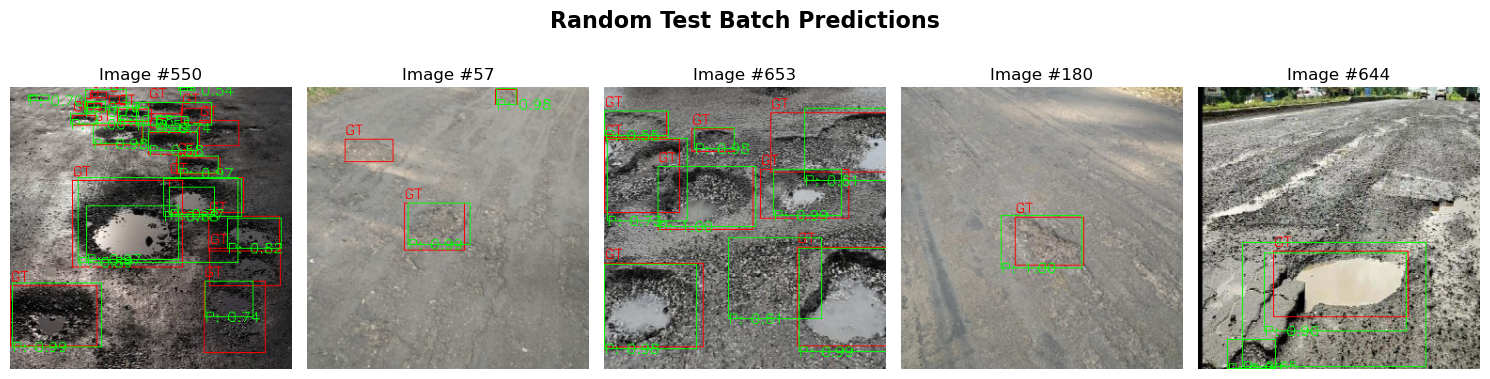

In [88]:
# Load the trained model
optuna_path = f'data/faster_rcnn/optuna'

# Load the best model
#checkpoint_path = os.path.join(optuna_path, f"model_trial_{study.best_trial.number}_best.pth")
#checkpoint_path = os.path.join(optuna_path, f"model_trial_48_best.pth")
checkpoint_path = f"data/faster_rcnn/faster_rcnn_pothole.pth"

model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(PotholeSeverity)) 
state_dict = torch.load(checkpoint_path, weights_only=True)
model.load_state_dict(state_dict)

model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

predictions, results, fps = evaluate_model(model, test_loader, num_iterations=1, threshold=0.5)

mean_ap_50=results["map_50"].item()
print(f"Mean Average Precision @ 0.5 : {mean_ap_50:.4f}",
      f"FPS: {fps:.2f}")

# Select a random batch
index = 3
#index = random.randint(0,len(list(test_loader)))  # Select a random batch
batches = list(test_loader)
images, targets = batches[index]

visualize_predictions(images, targets, predictions, mean=mean, std=std, threshold=0.5, show_severity=False)